In [3]:
import leafmap

# Define the paths to your NetCDF dataset and the output GeoTIFF file
datapath = '/home/mohamed/Documents/ERA5/Data/t2m_201801.nc'
tif = 't2m_201801.tif'  # Output GeoTIFF file

# Specify the variable name to be converted (e.g., 't2m' based on your dataset)
variable_name = 't2m'
lat_var = 'latitude'
lon_var = 'longitude'

# Convert the NetCDF dataset to GeoTIFF with latitude and longitude specified
leafmap.netcdf_to_tif(datapath, tif, variables=[variable_name], shift_lon=True, lat=lat_var, lon=lon_var)


'/home/mohamed/Documents/CDS-API-Connect/CDS-API-App/t2m_201801.tif'

In [1]:
from osgeo import gdal, osr
from netCDF4 import Dataset

# Input NetCDF file
input_nc_file = "/home/mohamed/Documents/ERA5/Data/t2m_201801.nc"

# Output GeoTIFF file
output_geotiff = "/home/mohamed/Documents/ERA5/Data/t2mconv.tif"

# Open the NetCDF file
nc_dataset = Dataset(input_nc_file, "r")

# Get the data array and dimensions
data = nc_dataset.variables['t2m'][0, :, :]  # Replace 'variable_name' with the actual variable name in your NetCDF file
x_dim = nc_dataset.variables['longitude']
y_dim = nc_dataset.variables['latitude']

# Create a new GeoTIFF file
driver = gdal.GetDriverByName("GTiff")
output_ds = driver.Create(output_geotiff, len(x_dim), len(y_dim), 1, gdal.GDT_Float32)

# Set the GeoTransform (assuming a regular grid)
x_start, x_step = x_dim[0], x_dim[1] - x_dim[0]
y_start, y_step = y_dim[0], y_dim[1] - y_dim[0]
output_ds.SetGeoTransform((x_start, x_step, 0, y_start, 0, y_step))

# Set the spatial reference (EPSG:4326 for WGS84)
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
output_ds.SetProjection(srs.ExportToWkt())

# Write the data to the GeoTIFF file
output_band = output_ds.GetRasterBand(1)
output_band.WriteArray(data)

# Close the datasets
output_ds = None
nc_dataset.close()

In [4]:
geojson = 'https://github.com/opengeos/leafmap/raw/master/examples/data/countries.geojson'

In [5]:
tif='/home/mohamed/Documents/CDS-API-Connect/CDS-API-App/t2m_201801.tif'

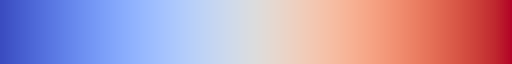

In [11]:
import matplotlib.pyplot as plt
plt.get_cmap('coolwarm')

In [ ]:
m = leafmap.Map(layers_control=True)
m.add_raster(tif, band=[1], palette='coolwarm', layer_name='t2m')
m.add_geojson(geojson, layer_name='Countries')
m

In [18]:
import folium
import xarray as xr
import numpy as np
import ipywidgets as widgets
from folium.plugins import HeatMap
from IPython.display import display

# Load the NetCDF file
netcdf_url = "/home/mohamed/Documents/ERA5/Data/t2m_20180106.nc"
ds = xr.open_dataset(netcdf_url)
t2m = ds["t2m"].values

# Create a Folium Map
m = folium.Map(location=[lat.mean(), lon.mean()], zoom_start=5)

# Get the latitude and longitude arrays
lat = ds["latitude"].values
lon = ds["longitude"].values

heatmaps = []
t2m_layer = folium.FeatureGroup(name='2m Temperature')  # Create a FeatureGroup for t2m data

def update_heatmap(time_step):
    if heatmaps:
        for heatmap in heatmaps:
            m.remove_child(heatmap)
        heatmaps.clear()

    heatmap_data = list(zip(lat, lon, t2m[time_step]))
    folium_heatmap = HeatMap(heatmap_data, radius=5, gradient={0.2: "blue", 0.4: "green", 0.6: "yellow", 1.0: "red"})
    m.add_child(folium_heatmap)
    heatmaps.append(folium_heatmap)

time_slider = widgets.IntSlider(min=0, max=t2m.shape[0] - 1, description="Time Step")
widgets.interactive(update_heatmap, time_step=time_slider)

# Add the t2m layer to the FeatureGroup
t2m_layer.add_to(m)

folium.LayerControl().add_to(m)

display(m)
